# Alternating Projections Algorithms for Nonnegative Low Rank Tensor Approximation

## 0.

In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from time import time

# import matplotlib_inline
# %matplotlib inline
# matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

In [2]:
norms = ['норма Чебышёва', 'норма Фробениуса', 'плотность']
colors = ['C0', 'C1', 'C2']
yticks = [10**(-x) for x in range(-1, 16, 2)]

In [3]:
def get_alg_name(alg, **params):
    if alg in ['SVD', 'Tangent']:
        return alg
    distr = params.get('distr')
    d = 'N' if distr=='normal' else 'Rad'
    if 'rho' in params.keys():
        rho = params.pop('rho')
    else:
        rho = None
    if alg == 'GN':
        p = list(params.values())[0]
        alg_name = f'{alg}({p}), {d}'
    else:
        if alg == 'HMT':
                p0 = params['p']
                p1 = params['k']
        elif alg == 'Tropp':
            p0 = params['k']
            p1 = params['l']
        alg_name = f'{alg}({p0},{p1}), {d}'
    if d == 'N':
        alg_name += '(0,1)'
    elif rho is not None:
        alg_name += f'({rho})'
    return alg_name

In [4]:
class Info:
    def __init__(self):
        self._info_l = None
        self._info_r = None
        
    def init(self, alg, params=None, l=0, r=None):
        self._alg = alg
        self._info_l = {'frobenius': [], 'chebyshev': [], 'density': []}
        if r is not None:
            self._info_r = {'frobenius': [], 'chebyshev': [], 'density': []}
        self._params  = params
        self._l = l
        self._r = r
  
    def clear(self):
        self._info_l = {'frobenius': [], 'chebyshev': [], 'density': []}
        if self._r is not None:
            self._info_r = {'frobenius': [], 'chebyshev': [], 'density': []}

    def update(self, a):
        a = a - self._l
        self._info_l['frobenius'].append(np.linalg.norm(a[a < 0]))
        neg_count = (a < 0).sum()
        self._info_l['density'].append(neg_count/(np.prod(a.shape)))
        self._info_l['chebyshev'].append(np.max(abs(a[a < 0]), initial=0))
        if self._r is not None:
            a = -(a - self._r)
            self._info_r['frobenius'].append(np.linalg.norm(a[a < 0]))
            neg_count = (a < 0).sum()
            self._info_r['density'].append(neg_count/(np.prod(a.shape)))
            self._info_r['chebyshev'].append(np.max(abs(a[a < 0]), initial=0))
        
    def get_info(self):
        if self._r is not None:
            return self._info_l, self._info_r
        else:
            return self._info_l
    
    def get_name(self):
        return get_alg_name(self._alg, **self._params)

In [5]:
class Svdr:
    def __init__(self, svdr, **params):
        self._svdr = svdr
        self._params = params
        
    def __call__(self, a, rank):
        if self._params:
            if self._svdr.__name__ == 'GN':
                Ur, Vhr = self._svdr(a, rank, **self._params)
            else:
                Ur, Sr, Vhr = self._svdr(a, rank, **self._params)
                Vhr = (Sr * Vhr.T).T
            return Ur, Vhr 
        else:
            Ur, Sr, Vhr = self._svdr(a, rank)
            return Ur, (Sr * Vhr.T).T
    
    def get_params(self):
        return self._params
    
    def get_svdr_name(self):
        return self._svdr.__name__
    
    def get_name(self):
        return get_alg_name(self._svdr.__name__, **self._params)

In [6]:
def TestMatrix(m, n, distribution='normal', p=None):
    if distribution == 'normal':
        res = np.random.normal(size=(m, n))
    elif distribution == 'rademacher' and p is None:
        res = np.random.choice([-1,1], size=(m,n))
    elif distribution == 'rademacher':
        res = np.random.choice([0,1,-1], size=(m,n), p=[1-p,p/2,p/2])
    else:
        raise TypeError('Invalid arguments')
    return res

In [7]:
def svdr(a, r):
    u, s, vh = sp.linalg.svd(a, full_matrices=False)
    return u[:, :r], s[:r], vh[:r, :]

## 1. Algorithms

### 1.1 SVD

In [8]:
def SVD(X, r):
    Ur, Sr, Vhr = svdr(X, r)
    
    return Ur, Sr, Vhr

### 1.2 Tangent

In [9]:
# def Tangent(X, r):
#     return Ur, Sr, Vhr

### 1.3 HMT

In [10]:
def HMT(X, rank, p, k, distr='normal', rho=None):
    m, n = X.shape

    Psi = TestMatrix(n, k, distr, rho)
    Z1 = X @ Psi
    Q, R = np.linalg.qr(Z1)
    for j in range(p):
        Z2 = Q.T @ X
        Q, R = np.linalg.qr(Z2.T)
        Z1 = X @ Q
        Q, R = np.linalg.qr(Z1)
    Z2 = Q.T @ X
    Ur, Sr, Vhr = svdr(Z2, rank)
    Ur = Q @ Ur
    
    return Ur, Sr, Vhr

### 1.4 Tropp

In [11]:
def Tropp(X, rank, k, l, distr='normal', rho=None):
    m, n = X.shape
        
    Psi = TestMatrix(n, k, distr, rho)
    Phi = TestMatrix(l, m, distr, rho)
    Z = X @ Psi
    Q, R = np.linalg.qr(Z)
    W = Phi @ Q
    P, T = np.linalg.qr(W)
    G = np.linalg.inv(T) @ P.T @ Phi @ X
    Ur, Sr, Vhr = svdr(G, rank)
    Ur = Q @ Ur
    
    return Ur, Sr, Vhr

### 1.5 GN (generalized Nystrom method)

In [12]:
def GN(X, rank, l, distr='normal', rho=None):
    m, n = X.shape

    Psi = TestMatrix(n, rank, distr, rho)
    Phi = TestMatrix(l, m, distr, rho)
    Z = X @ Psi
    W = Phi @ Z
    Q, R = np.linalg.qr(W)
    V = (Phi@X).T @ Q
    U = Z @ np.linalg.inv(R)
        
    return U, V.T

## 2. Alternating projections

### 2.0

In [13]:
def unfold(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1))

def fold(unfolded_tensor, mode, shape):
    full_shape = list(shape)
    mode_dim = full_shape.pop(mode)
    full_shape.insert(0, mode_dim)
    return np.moveaxis(np.reshape(unfolded_tensor, full_shape), 0, mode)

def mode_product(tensor, matrix, mode):
    if tensor.shape[mode] != matrix.shape[0]:
        raise RuntimeError(f'tensor.shape[{mode}] != matrix.shape[0]')
    new_shape = list(tensor.shape)
    new_shape[mode] = matrix.shape[1]
    tensor_mode = unfold(tensor, mode)
    return fold(matrix.T @ tensor_mode, mode, new_shape)

### 2.1 HOSVD-based algorithm for nonnegative tensor approximation

In [14]:
def HOSVD(tensor, ranks):
    S = tensor.copy()
    U_list = []
    for k in range(len(tensor.shape)):
        ak = unfold(S, k)
        u, s, vh  = svdr(ak, ranks[k])
        vh = (s * vh.T).T
        shape = list(S.shape)
        shape[k] = ranks[k]
        S = fold(vh, k, shape)
        U_list.append(u)
    return S, U_list

def myHOSVD(tensor, ranks, svdr, iters_num=100, left=0, right=None, info=None): # alternating projections
    if info is not None:
        info.init(svdr.get_svdr_name(), svdr.get_params(), l=left, r=right)
    for i in range(iters_num):
        S = tensor.copy()
        U_list = []
        S[S < left] = left
        if right is not None:
            S[S > right] = right
        for k in range(len(tensor.shape)):
            Sk = unfold(S, k)
            Ur, Vhr = svdr(Sk, ranks[k])
            shape = list(S.shape)
            shape[k] = ranks[k]
            S = fold(Vhr, k, shape)
            U_list.append(Ur)
        tensor = restore_tensor_hosvd(S, U_list)
        if info is not None:
            info.update(tensor)
    return S, U_list

def restore_tensor_hosvd(s, u_list):
    res = mode_product(s, u_list[0].T, 0)
    for k, u in enumerate(u_list[1:], 1):
        res = mode_product(res, u.T, k)
    return res

### 2.2 TT-SVD-based algorithm for nonnegative tensor approximation

In [15]:
def TTSVD(tensor, r):
    n = np.array(tensor.shape)
    G_list = []

    G = tensor.copy()
    G0 = unfold(G, 0)
    u, s, vh = svdr(G0, r[0])
    vh = (s * vh.T).T
    G_list.append(u)
    for k in range(1, len(tensor.shape)-1):
        vh = vh.reshape(r[k-1]*n[k], np.prod(n[k+1:]))
        u, s, vh = svdr(vh, r[k])
        vh = (s * vh.T).T
        r_cur = min(r[k], vh.shape[0])
        u = u.reshape(r[k-1], n[k], r_cur)
        G_list.append(u)
    G_list.append(vh)
    
    return G_list

def myTTSVD(tensor, ranks, svdr, iters_num=100, left=0, right=None, info=None): # alternating projections
    if info is not None:
        info.init(svdr.get_svdr_name(), svdr.get_params(), l=left, r=right)
    n = np.array(tensor.shape)
    for i in range(iters_num):
        G_list = []
        G = tensor.copy()
        G[G < left] = left
        if right is not None:
            G[G > right] = right
        G0 = unfold(G, 0)
        Ur, Vhr = svdr(G0, ranks[0])
        G_list.append(Ur)
        for k in range(1, len(tensor.shape)-1):
            Vhr = Vhr.reshape(ranks[k-1]*n[k], np.prod(n[k+1:]))
            Ur, Vhr = svdr(Vhr, ranks[k])
            r_cur = min(ranks[k], Vhr.shape[0])
            Ur = Ur.reshape(ranks[k-1], n[k], r_cur)
            G_list.append(Ur)
        G_list.append(Vhr)
        tensor = restore_tensor_ttsvd(G_list)
        if info is not None:
            info.update(tensor)
    return G_list   

def restore_tensor_ttsvd(g_list):
    res = mode_product(g_list[1], g_list[0].T, 0)
    for k in range(2, len(g_list)-1):
        g = g_list[k]
        new_shape = list(res.shape[:-1]) + list(g.shape[1:])
        g = unfold(g, 0)
        res = mode_product(res, g, k)
        res = res.reshape(new_shape)
    res = mode_product(res, g_list[-1], len(res.shape)-1)
    return res

## 3. Numerical experiments

### 3.1 Color image 512x512

In [16]:
img = mpimg.imread('img3D.jpg')
img = img / 255
ranks_hosvd = [60, 60, 3]
ranks_ttsvd = [60, 60]

iters_num = 700
right = 1

print('min/max: %.1f, %.1f' % (img.min(), img.max()))
print('img_shape:', img.shape)

min/max: 0.0, 1.0
img_shape: (512, 512, 3)


In [17]:
# SVD_r

algs  = [HOSVD, TTSVD]
ranks = [ranks_hosvd, ranks_ttsvd]
restore_tensor = [restore_tensor_hosvd, restore_tensor_ttsvd]
imgs = []
line = '-' * 37
print(line)
for i in range(2):
    alg = algs[i]
    r = ranks[i]
    rt = restore_tensor[i]
    print(alg.__name__)
    print(line)
    
    start = time()
    g = alg(img, r)
    end = time()
    print('time (s.)                   | %.5f' % (end-start))
    
    if len(g) == 2:
        imgr = rt(g[0], g[1])
    else:
        imgr = rt(g)
    
    imgs.append(imgr)
    print('negative elements (fro)     | %.5f' % np.linalg.norm(imgr[imgr < 0]))
    print('negative elements (che)     | %.5f' % np.max(abs(imgr[imgr < 0]), initial=0))
    neg_count = (imgr < 0).sum()
    print('negative elements (density) | %.5f' % (neg_count/(np.prod(imgr.shape))))
    print('relative error (fro)        | %.5f' % (np.linalg.norm(img - imgr)/np.linalg.norm(img)))
    print('relative error (che)        | %.5f' % (np.max(abs(img - imgr)/ np.max(abs(img)))))
    print(line)

-------------------------------------
HOSVD
-------------------------------------
time (s.)                   | 0.44094
negative elements (fro)     | 0.86341
negative elements (che)     | 0.08754
negative elements (density) | 0.00152
relative error (fro)        | 0.03748
relative error (che)        | 0.29463
-------------------------------------
TTSVD
-------------------------------------
time (s.)                   | 0.36359
negative elements (fro)     | 0.86047
negative elements (che)     | 0.07819
negative elements (density) | 0.00153
relative error (fro)        | 0.03365
relative error (che)        | 0.27330
-------------------------------------


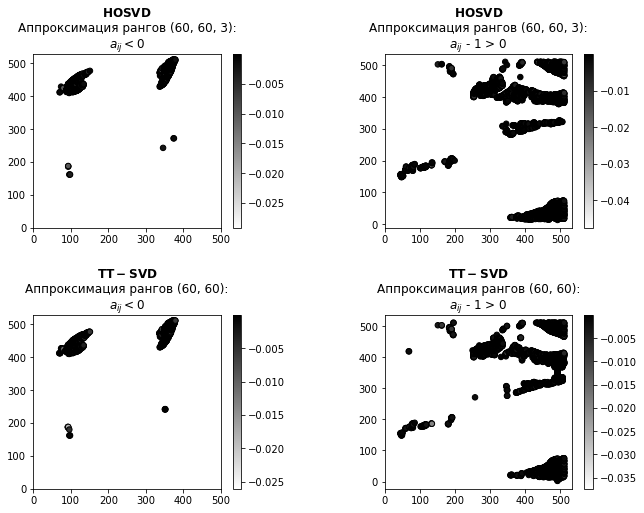

In [18]:
alg_names = ['$\\bf{HOSVD}$', '$\\bf{TT-SVD}$']
t_subs = ['Аппроксимация рангов (%d, %d, %d)' % tuple(ranks_hosvd),\
          'Аппроксимация рангов (%d, %d)' % tuple(ranks_ttsvd)]
right = 1

fig, ax = plt.subplots(2, 2, figsize=(10.5, 8))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for i in range(2):
    img_ = imgs[i]
    alg_name = alg_names[i]
    t_sub = t_subs[i]
    
    img_r = img_.copy()
    img_r[img_r > 0] = 0
    img_r = img_r.mean(axis=2)
    plt.set_cmap('gray_r')
    ax[i,0].set_title('%s\n%s:\n$a_{ij} < 0$' % (alg_name, t_sub))
    sc = ax[i,0].scatter(*np.where(img_r < 0), s=30, c=img_r[np.where(img_r < 0)], edgecolors='black')
    plt.colorbar(sc, ax=ax[i,0])

    img_r = -(img_.copy() - right)
    img_r[img_r > 0] = 0
    img_r = img_r.mean(axis=2)
    ax[i,1].set_title('%s\n%s:\n$a_{ij}$ - %d > 0' % (alg_name, t_sub, right))
    sc2 = ax[i,1].scatter(*np.where(img_r < 0), s=30, c=img_r[np.where(img_r < 0)], edgecolors='black')
    plt.colorbar(sc2, ax=ax[i,1])

    ax[i,0].set_xticks(range(0, img.shape[0], 100))
    ax[i,0].set_yticks(range(0, img.shape[1], 100))
    ax[i,1].set_xticks(range(0, img.shape[0], 100))
    ax[i,1].set_yticks(range(0, img.shape[1], 100))

In [19]:
params_hosvd = [dict(p=1,   k=70,  distr='normal'),\
                dict(p=0,   k=70,  distr='rademacher', rho=0.2),\
                dict(k=70,  l=100, distr='rademacher', rho=0.2),\
                dict(l=150,        distr='normal',     rho=0.2),\
                dict(l=150,        distr='rademacher', rho=0.2)]
params_ttsvd = [dict(p=1,   k=70,  distr='normal'),\
                dict(p=0,   k=70,  distr='rademacher', rho=0.2),\
                dict(k=70,  l=100, distr='normal',     rho=0.2),\
                dict(k=70,  l=100, distr='rademacher', rho=0.2),\
                dict(l=150,        distr='normal',     rho=0.2)]
algs_hosvd = [Svdr(SVD)]
algs_ttsvd = [Svdr(SVD)]
for i, alg in enumerate([HMT, HMT, Tropp, GN, GN]):
    algs_hosvd.append(Svdr(alg, **params_hosvd[i]))
for i, alg in enumerate([HMT, HMT, Tropp, Tropp, GN]):
    algs_ttsvd.append(Svdr(alg, **params_ttsvd[i]))

In [20]:
## timeit | img in [0,1]

line = '-' * 35
print(line)
print('HOSVD')
print(line)
for i in range(len(algs_hosvd)):
    t0 = time()
    myHOSVD(img, ranks_hosvd, algs_hosvd[i], iters_num=iters_num, right=right)
    t1 = time()
    print('%-23s | %6.2f s.' % (algs_hosvd[i].get_name(), t1-t0))

print(line)
print('TT-SVD')
print(line)
for i in range(len(algs_ttsvd)):
    t0 = time()
    myTTSVD(img, ranks_ttsvd, algs_ttsvd[i], iters_num=iters_num, right=right)
    t1 = time()
    print('%-23s | %6.2f s.' % (algs_ttsvd[i].get_name(), t1-t0))
print(line)

-----------------------------------
HOSVD
-----------------------------------
SVD                     | 261.44 s.
HMT(1,70), N(0,1)       |  45.27 s.
HMT(0,70), Rad(0.2)     |  28.90 s.
Tropp(70,100), Rad(0.2) |  33.53 s.
GN(150), N(0,1)         |  29.21 s.
GN(150), Rad(0.2)       |  26.10 s.
-----------------------------------
TT-SVD
-----------------------------------
SVD                     | 232.68 s.
HMT(1,70), N(0,1)       | 114.06 s.
HMT(0,70), Rad(0.2)     | 105.50 s.
Tropp(70,100), N(0,1)   | 230.42 s.
Tropp(70,100), Rad(0.2) | 202.01 s.
GN(150), N(0,1)         | 278.44 s.
-----------------------------------


In [21]:
info_list_hosvd = []
info_list_ttsvd = []
img_list_hosvd  = []
img_list_ttsvd  = []
    
line = '-' * 35
print(line)
print('HOSVD')
print(line)
for i in range(len(algs_hosvd)):
    info = Info()
    t0 = time()
    S, U_list = myHOSVD(img, ranks_hosvd, algs_hosvd[i], iters_num=iters_num, right=right, info=info)
    t1 = time()
    print('%-23s | %6.2f s.' % (algs_hosvd[i].get_name(), t1-t0))
    img_list_hosvd.append(restore_tensor_hosvd(S, U_list))
    info_list_hosvd.append(info)

print(line)
print('TT-SVD')
print(line)
for i in range(len(algs_ttsvd)):
    info = Info()
    t0 = time()
    G_list = myTTSVD(img, ranks_ttsvd, algs_ttsvd[i], iters_num=iters_num, right=right, info=info)
    t1 = time()
    print('%-23s | %6.2f s.' % (algs_ttsvd[i].get_name(), t1-t0))
    img_list_ttsvd.append(restore_tensor_ttsvd(G_list))
    info_list_ttsvd.append(info)
print(line)

-----------------------------------
HOSVD
-----------------------------------
SVD                     | 250.57 s.
HMT(1,70), N(0,1)       |  67.85 s.
HMT(0,70), Rad(0.2)     |  45.46 s.
Tropp(70,100), Rad(0.2) |  49.54 s.
GN(150), N(0,1)         |  40.01 s.
GN(150), Rad(0.2)       |  34.52 s.
-----------------------------------
TT-SVD
-----------------------------------
SVD                     | 227.97 s.
HMT(1,70), N(0,1)       | 119.51 s.
HMT(0,70), Rad(0.2)     | 108.13 s.
Tropp(70,100), N(0,1)   | 253.36 s.
Tropp(70,100), Rad(0.2) | 192.39 s.
GN(150), N(0,1)         | 266.72 s.
-----------------------------------


In [22]:
info_list = [info_list_hosvd, info_list_ttsvd]
img_list  = [img_list_hosvd, img_list_ttsvd]
alg_names = ['HOSVD', 'TT-SVD']
line = '-' * 73

for j in range(2):
    print(line)
    print('| %-23s | %s (fro) | %s (che) |' % (alg_names[j], 'relative error', 'relative error'))
    print(line)
    for i in range(len(info_list_hosvd)):
        info = info_list[j][i]
        imgr = img_list[j][i]
        fro = np.linalg.norm(img - imgr) / np.linalg.norm(img)
        che = np.max(abs(img - imgr)) / np.max(abs(img))
        print('| %-23s | %20.5f | %20.5f |' % (info.get_name(), fro, che))
print(line)

-------------------------------------------------------------------------
| HOSVD                   | relative error (fro) | relative error (che) |
-------------------------------------------------------------------------
| SVD                     |              0.03779 |              0.30185 |
| HMT(1,70), N(0,1)       |              0.03885 |              0.30968 |
| HMT(0,70), Rad(0.2)     |              0.05845 |              0.36752 |
| Tropp(70,100), Rad(0.2) |              0.12445 |              0.61433 |
| GN(150), N(0,1)         |              0.09276 |              0.50050 |
| GN(150), Rad(0.2)       |              0.09560 |              0.52234 |
-------------------------------------------------------------------------
| TT-SVD                  | relative error (fro) | relative error (che) |
-------------------------------------------------------------------------
| SVD                     |              0.03388 |              0.28833 |
| HMT(1,70), N(0,1)       |           

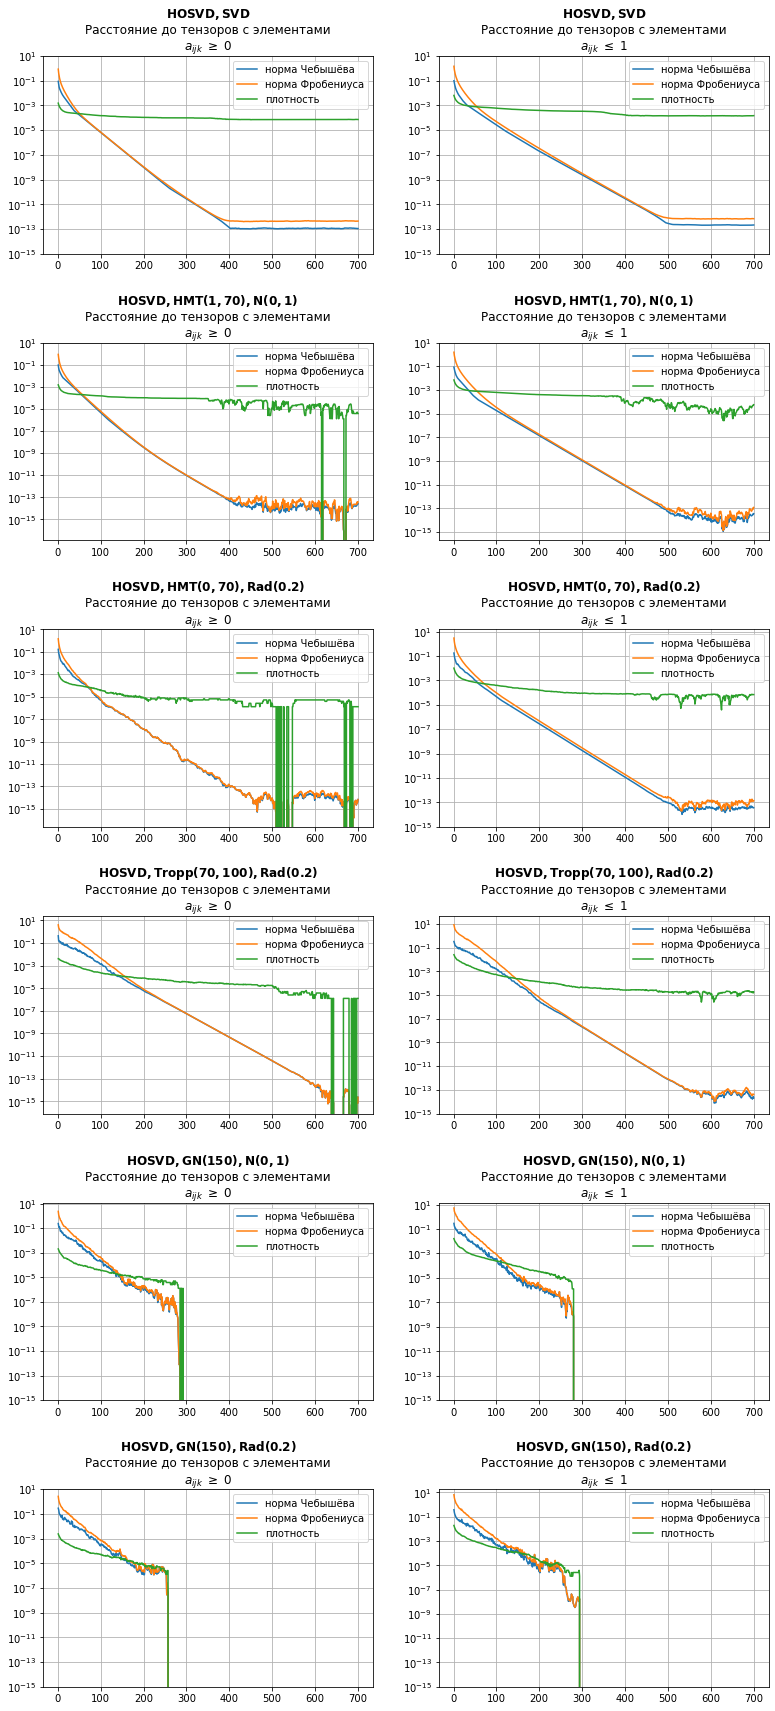

In [23]:
# HOSVD

titles = ['Расстояние до тензоров с элементами\n$a_{ijk}$ $\geq$ 0',\
          'Расстояние до тензоров с элементами\n$a_{ijk}$ $\leq$ 1']
fig, ax = plt.subplots(len(info_list_hosvd), 2, figsize= (13, 30))   # (13, 60)

for i in range(len(info_list_hosvd)):
    info = info_list_hosvd[i].get_info()
    alg_name = info_list_hosvd[i].get_name()
    for j in range(2):
        ax[i,j].plot(range(1, iters_num+1), info[j]['chebyshev'], colors[0], label=norms[0])
        ax[i,j].plot(range(1, iters_num+1), info[j]['frobenius'], colors[1], label=norms[1])
        ax[i,j].plot(range(1, iters_num+1), info[j]['density'],   colors[2], label=norms[2])
        ax[i,j].set_yscale('log')
        ax[i,j].set_yticks(yticks)
        ax[i,j].set_title('$\\bf{%s, %s}$\n%s' % ('HOSVD', alg_name, titles[j]))
        ax[i,j].legend()
        ax[i,j].grid()

plt.subplots_adjust(wspace=0.2, hspace=0.45)

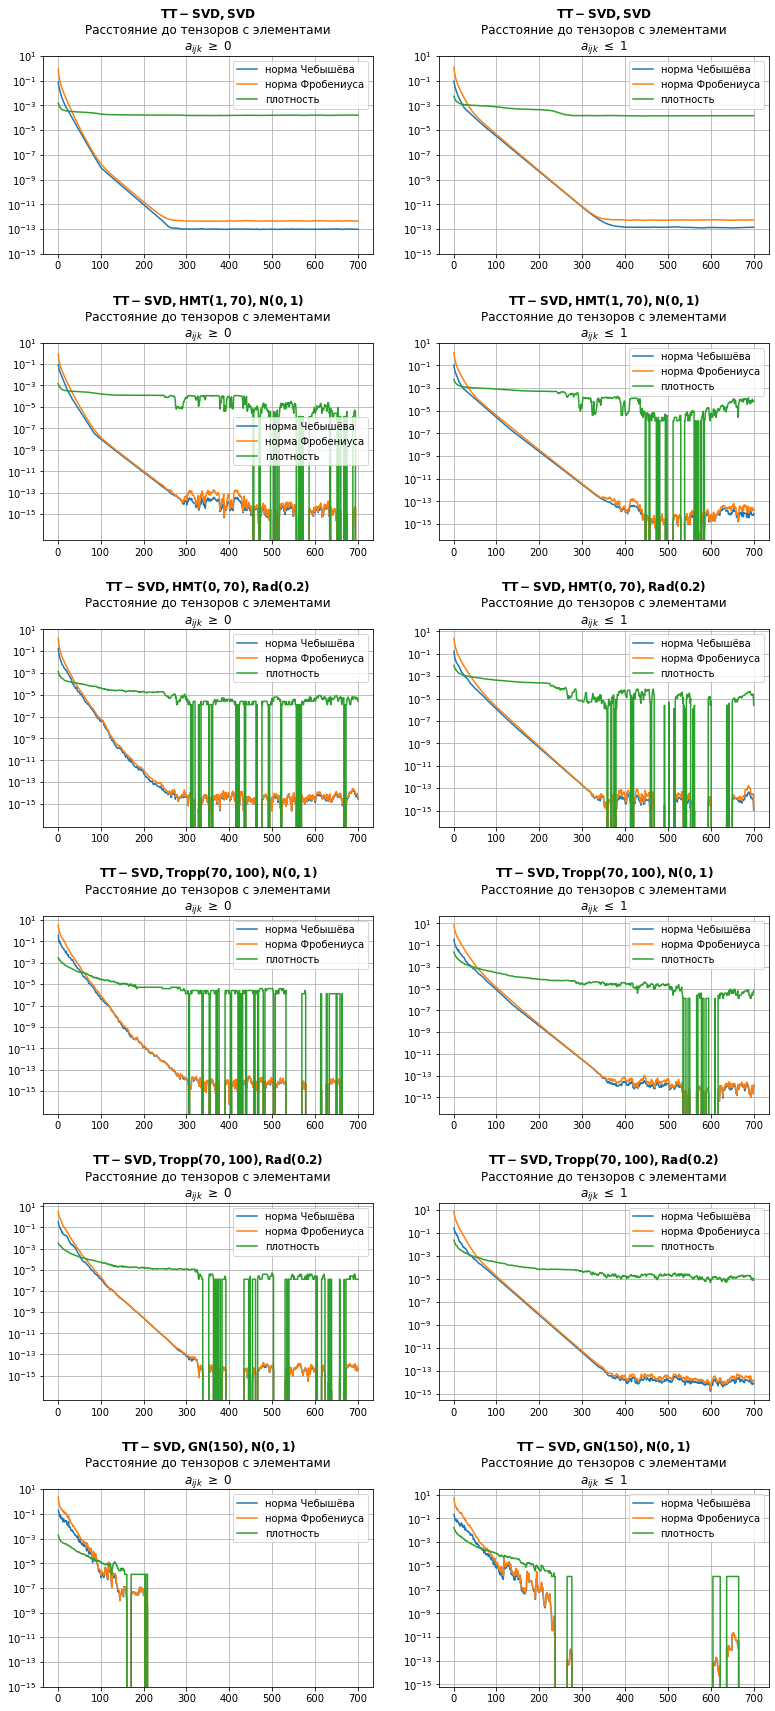

In [24]:
# TT-SVD

fig, ax = plt.subplots(len(info_list_ttsvd), 2, figsize=(13, 30)) # (13, 55)

for i in range(len(info_list_ttsvd)):
    info = info_list_ttsvd[i].get_info()
    alg_name = info_list_ttsvd[i].get_name()
    for j in range(2):
        ax[i,j].plot(range(1, iters_num+1), info[j]['chebyshev'], colors[0], label=norms[0])
        ax[i,j].plot(range(1, iters_num+1), info[j]['frobenius'], colors[1], label=norms[1])
        ax[i,j].plot(range(1, iters_num+1), info[j]['density'],   colors[2], label=norms[2])
        ax[i,j].set_yscale('log')
        ax[i,j].set_yticks(yticks)
        ax[i,j].set_title('$\\bf{%s, %s}$\n%s' % ('TT-SVD', alg_name, titles[j]))
        ax[i,j].legend()
        ax[i,j].grid()

plt.subplots_adjust(wspace=0.2, hspace=0.45)

In [25]:
# for i in range(m):   
#     extent = ax[i,0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#     extent.x0 -= 0.5
#     extent.x1 += 5.7
#     extent.y1 += 0.7
#     extent.y0 -= 0.3
#     fname = 'img_2_%d.pdf' % i
#     fig.savefig(fname, transparent=True, bbox_inches=extent)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


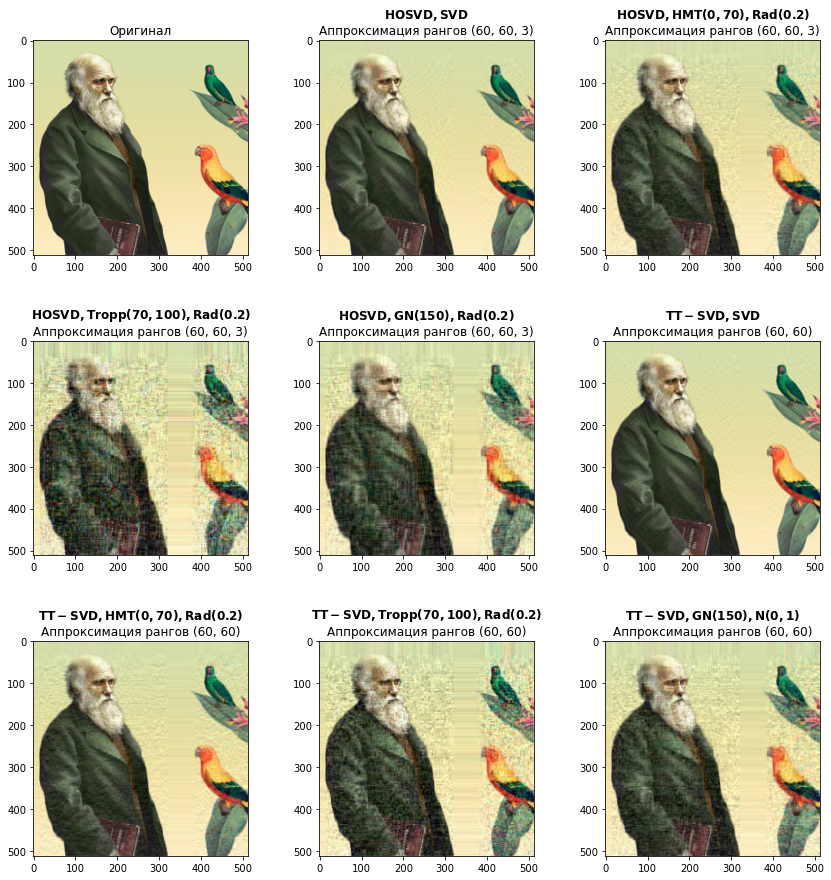

In [27]:
t1 = 'Аппроксимация рангов (%d, %d, %d)' % tuple(ranks_hosvd)
t2 = 'Аппроксимация рангов (%d, %d)'     % tuple(ranks_ttsvd)

fig, ax = plt.subplots(3, 3, figsize=(15, 15))

inds = [[0, 2, 3, 5],\
        [0, 2, 4, 5]]
for k in range(9):
    i = k//3
    j = k % 3
    if k <= 4:
        t = 'HOSVD'
        subt = t1
        info = info_list_hosvd[inds[0][k-1]]
        imgr = img_list_hosvd[inds[0][k-1]]
    else:
        t = 'TT-SVD'
        subt = t2
        info = info_list_ttsvd[inds[1][k-5]]
        imgr = img_list_ttsvd[inds[1][k-5]]
    title = '$\\bf{%s, %s}$\n%s' % (t, info.get_name(), subt)
    if k == 0:
        title = 'Оригинал'
        imgr  = img
    ax[i,j].set_title(title)
    ax[i,j].set_xticks(range(0, 513, 100))
    ax[i,j].set_yticks(range(0, 513, 100))
    ax[i,j].imshow(imgr)
   
plt.subplots_adjust(wspace=0.08, hspace=0.4)

In [ ]:
# for i in range(3):   
#     extent = ax[i,0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#     extent.x0 -= 0.4
#     extent.x1 += 8.2
#     extent.y1 += 0.5
#     extent.y0 -= 0.3
#     fname = 'img_1_%d.pdf' % (i)
#     fig.savefig(fname, transparent=True, bbox_inches=extent)

### 3.2 Random 3D tensor

In [28]:
n = 128
a = np.random.uniform(low=0, high=255, size=(n,n,n))

ranks_hosvd = [60, 60, 60]
ranks_ttsvd = [60, 60]
iters_num_hosvd = 1000
iters_num_ttsvd = 600

In [29]:
# SVD_r

algs  = [HOSVD, TTSVD]
ranks = [ranks_hosvd, ranks_ttsvd]
restore_tensor = [restore_tensor_hosvd, restore_tensor_ttsvd]
line = '-' * 39
print(line)
for i in range(2):
    alg = algs[i]
    r = ranks[i]
    rt = restore_tensor[i]
    print(alg.__name__)
    print(line)
    
    start = time()
    g = alg(a, r)
    end = time()
    print('time (s.)                   | %9.5f' % (end-start))
    
    if len(g) == 2:
        ar = rt(g[0], g[1])
    else:
        ar = rt(g)

    print('negative elements (fro)     | %9.5f' % np.linalg.norm(ar[ar < 0]))
    print('negative elements (che)     | %9.5f' % np.max(abs(ar[ar < 0]), initial=0))
    neg_count = (ar < 0).sum()
    print('negative elements (density) | %9.5f' % (neg_count/(np.prod(ar.shape))))
    print('relative error (fro)        | %9.5f' % (np.linalg.norm(a - ar)/np.linalg.norm(a)))
    print('relative error (che)        | %9.5f' % (np.max(abs(a - ar)/ np.max(abs(a)))))
    print(line)

---------------------------------------
HOSVD
---------------------------------------
time (s.)                   |   0.46574
negative elements (fro)     |  49.69209
negative elements (che)     |  28.35136
negative elements (density) |   0.00001
relative error (fro)        |   0.46231
relative error (che)        |   0.91705
---------------------------------------
TTSVD
---------------------------------------
time (s.)                   |   0.36201
negative elements (fro)     | 346.11442
negative elements (che)     |  54.67639
negative elements (density) |   0.00035
relative error (fro)        |   0.42867
relative error (che)        |   0.95223
---------------------------------------


In [30]:
params_hosvd = [dict(p=1,   k=70,  distr='normal'),\
                dict(p=0,   k=70,  distr='rademacher', rho=0.2),\
                dict(k=75,  l=110, distr='rademacher', rho=0.2),\
                dict(l=150,        distr='normal',     rho=0.2),\
                dict(l=150,        distr='rademacher', rho=0.2)]
params_ttsvd = [dict(p=1,   k=70,  distr='normal'),\
                dict(p=0,   k=70,  distr='rademacher', rho=0.2),\
                dict(k=75,  l=110, distr='normal',     rho=0.2),\
                dict(k=70,  l=100, distr='rademacher', rho=0.2),\
                dict(l=150,        distr='normal',     rho=0.2)]
algs_hosvd = [Svdr(SVD)]
algs_ttsvd = [Svdr(SVD)]
for i, alg in enumerate([HMT, HMT, Tropp, GN, GN]):
    algs_hosvd.append(Svdr(alg, **params_hosvd[i]))
for i, alg in enumerate([HMT, HMT, Tropp, Tropp, GN]):
    algs_ttsvd.append(Svdr(alg, **params_ttsvd[i]))

In [31]:
## timeit

line = '-' * 35
print(line)
print('HOSVD')
print(line)
for i in range(len(algs_hosvd)):
    t0 = time()
    myHOSVD(a, ranks_hosvd, algs_hosvd[i], iters_num=iters_num_hosvd)
    t1 = time()
    print('%-23s | %6.2f s.' % (algs_hosvd[i].get_name(), t1-t0))

print(line)
print('TT-SVD')
print(line)
for i in range(len(algs_ttsvd)):
    t0 = time()
    myTTSVD(a, ranks_ttsvd, algs_ttsvd[i], iters_num=iters_num_ttsvd)
    t1 = time()
    print('%-23s | %6.2f s.' % (algs_ttsvd[i].get_name(), t1-t0))
print(line)

-----------------------------------
HOSVD
-----------------------------------
SVD                     | 552.06 s.
HMT(1,70), N(0,1)       | 369.15 s.
HMT(0,70), Rad(0.2)     | 245.54 s.
Tropp(75,110), Rad(0.2) | 268.52 s.
GN(150), N(0,1)         | 204.43 s.
GN(150), Rad(0.2)       | 162.94 s.
-----------------------------------
TT-SVD
-----------------------------------
SVD                     | 292.18 s.
HMT(1,70), N(0,1)       | 185.57 s.
HMT(0,70), Rad(0.2)     | 116.07 s.
Tropp(75,110), N(0,1)   | 179.38 s.
Tropp(70,100), Rad(0.2) | 137.33 s.
GN(150), N(0,1)         | 129.36 s.
-----------------------------------


In [32]:
ar_info_list_hosvd = []
ar_info_list_ttsvd = []
ar_list_hosvd = []
ar_list_ttsvd = []
    
line = '-' * 35
print(line)
print('HOSVD')
print(line)
for i in range(len(algs_hosvd)):
    info = Info()
    t0 = time()
    S, U_list = myHOSVD(a, ranks_hosvd, algs_hosvd[i], iters_num=iters_num_hosvd, info=info)
    t1 = time()
    print('%-23s | %6.2f s.' % (algs_hosvd[i].get_name(), t1-t0))
    ar_list_hosvd.append(restore_tensor_hosvd(S, U_list))
    ar_info_list_hosvd.append(info)

print(line)
print('TT-SVD')
print(line)
for i in range(len(algs_ttsvd)):
    info = Info()
    t0 = time()
    G_list = myTTSVD(a, ranks_ttsvd, algs_ttsvd[i], iters_num=iters_num_ttsvd, info=info)
    t1 = time()
    print('%-23s | %6.2f s.' % (algs_ttsvd[i].get_name(), t1-t0))
    ar_list_ttsvd.append(restore_tensor_ttsvd(G_list))
    ar_info_list_ttsvd.append(info)
print(line)

-----------------------------------
HOSVD
-----------------------------------
SVD                     | 706.07 s.
HMT(1,70), N(0,1)       | 555.78 s.
HMT(0,70), Rad(0.2)     | 307.31 s.
Tropp(75,110), Rad(0.2) | 284.68 s.
GN(150), N(0,1)         | 215.62 s.
GN(150), Rad(0.2)       | 181.53 s.
-----------------------------------
TT-SVD
-----------------------------------
SVD                     | 301.75 s.
HMT(1,70), N(0,1)       | 211.88 s.
HMT(0,70), Rad(0.2)     | 122.19 s.
Tropp(75,110), N(0,1)   | 192.68 s.
Tropp(70,100), Rad(0.2) | 147.04 s.
GN(150), N(0,1)         | 137.08 s.
-----------------------------------


In [33]:
ar_info_list = [ar_info_list_hosvd, ar_info_list_ttsvd]
ar_list = [ar_list_hosvd, ar_list_ttsvd]
alg_names  = ['HOSVD', 'TT-SVD']
line = '-' * 73

for j in range(2):
    print(line)
    print('| %-23s | %s (fro) | %s (che) |' % (alg_names[j], 'relative error', 'relative error'))
    print(line)
    for i in range(len(ar_info_list_hosvd)):
        info = ar_info_list[j][i]
        ar = ar_list[j][i]
        fro = np.linalg.norm(a - ar) / np.linalg.norm(a)
        che = np.max(abs(a - ar)) / np.max(abs(a))
        print('| %-23s | %20.5f | %20.5f |' % (info.get_name(), fro, che))
print(line)

-------------------------------------------------------------------------
| HOSVD                   | relative error (fro) | relative error (che) |
-------------------------------------------------------------------------
| SVD                     |              0.46231 |              0.91705 |
| HMT(1,70), N(0,1)       |              0.46920 |              0.88413 |
| HMT(0,70), Rad(0.2)     |              0.47496 |              0.88520 |
| Tropp(75,110), Rad(0.2) |              0.95667 |              3.60252 |
| GN(150), N(0,1)         |              0.57182 |              1.47512 |
| GN(150), Rad(0.2)       |              0.57964 |              1.47512 |
-------------------------------------------------------------------------
| TT-SVD                  | relative error (fro) | relative error (che) |
-------------------------------------------------------------------------
| SVD                     |              0.42869 |              0.94600 |
| HMT(1,70), N(0,1)       |           

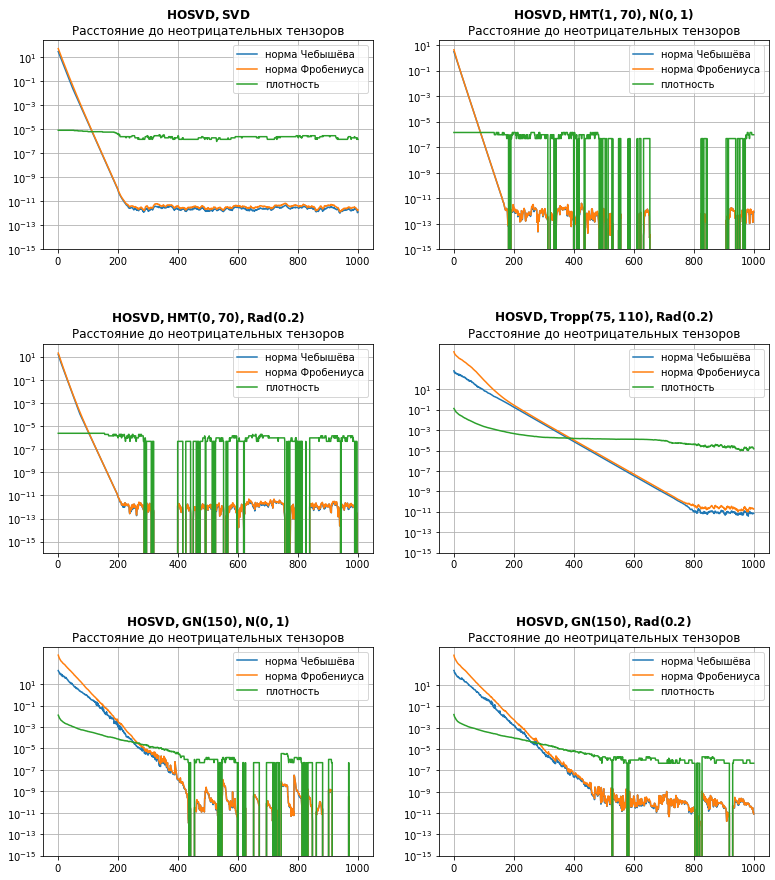

In [34]:
# HOSVD

title = 'Расстояние до неотрицательных тензоров'
info_list = ar_info_list_hosvd
fig, ax = plt.subplots(3, 2, figsize= (13, 15))   # (13, 60)

for k in range(len(info_list)):
    info = info_list[k].get_info()
    alg_name = info_list[k].get_name()
    i = k // 2
    j = k % 2
    ax[i,j].plot(range(1, iters_num_hosvd+1), info['chebyshev'], colors[0], label=norms[0])
    ax[i,j].plot(range(1, iters_num_hosvd+1), info['frobenius'], colors[1], label=norms[1])
    ax[i,j].plot(range(1, iters_num_hosvd+1), info['density'],   colors[2], label=norms[2])
    ax[i,j].set_yscale('log')
    ax[i,j].set_yticks(yticks)
    ax[i,j].set_title('$\\bf{%s, %s}$\n%s' % ('HOSVD', alg_name, title))
    ax[i,j].legend()
    ax[i,j].grid()

plt.subplots_adjust(wspace=0.2, hspace=0.45)

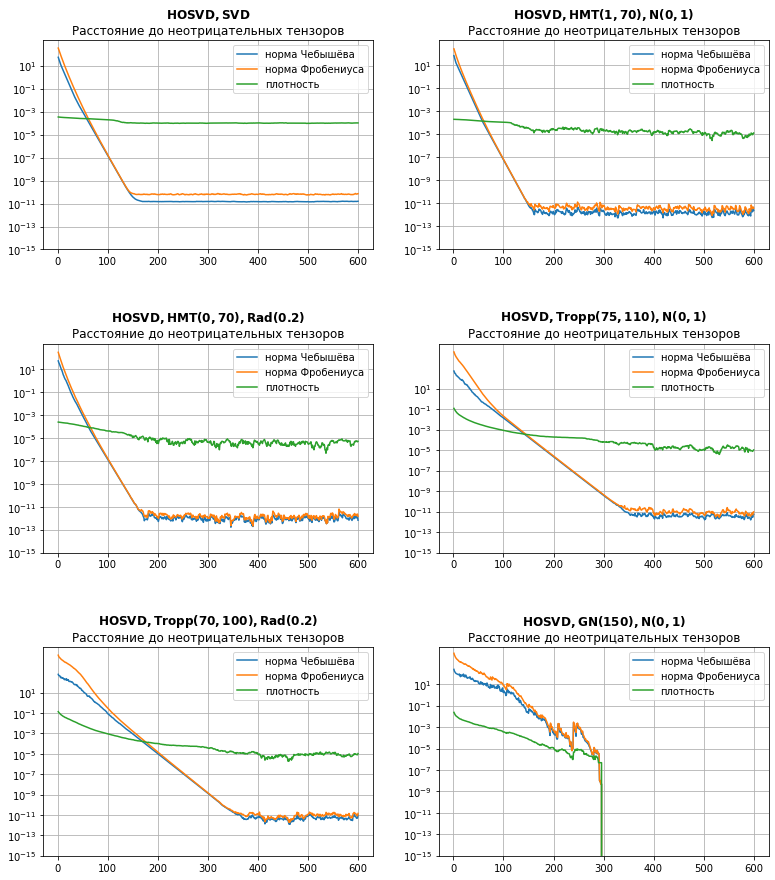

In [35]:
# TT-SVD

title = 'Расстояние до неотрицательных тензоров'
info_list = ar_info_list_ttsvd
fig, ax = plt.subplots(3, 2, figsize= (13, 15))   # (13, 60)

for k in range(len(info_list)):
    info = info_list[k].get_info()
    alg_name = info_list[k].get_name()
    i = k // 2
    j = k % 2
    ax[i,j].plot(range(1, iters_num_ttsvd+1), info['chebyshev'], colors[0], label=norms[0])
    ax[i,j].plot(range(1, iters_num_ttsvd+1), info['frobenius'], colors[1], label=norms[1])
    ax[i,j].plot(range(1, iters_num_ttsvd+1), info['density'],   colors[2], label=norms[2])
    ax[i,j].set_yscale('log')
    ax[i,j].set_yticks(yticks)
    ax[i,j].set_title('$\\bf{%s, %s}$\n%s' % ('HOSVD', alg_name, title))
    ax[i,j].legend()
    ax[i,j].grid()

plt.subplots_adjust(wspace=0.2, hspace=0.45)